# Image compression using Principal Component Analysis

Using a subset of the EMNIST data, find the PCA components of an image, and show it's reconstruction.

    ISE 201 Fall 2024    (c) JMA

In [2]:
%matplotlib inline
# utils
import os, re, math
import gzip
import struct
import pyarrow
from pathlib import Path
from dataclasses import dataclass

# A library specific to colab for mounting Google Drive folders
# from google.colab import drive

# numbers
import numpy as np
import numpy.random as rn
import pandas as pd


# stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# plots
import matplotlib.pyplot as plt
import seaborn as sns
# Import the bokeh python wrappers for javascript plots
#  - a preferred visualization tool
from bokeh.plotting import figure, show, row, save
from bokeh.models import ColumnDataSource, VBar, Span, Text, Label
from bokeh.io import output_notebook, output_file
output_notebook()


Loading BokehJS ...

In [3]:
# globals

DATA_DIR = Path('../data/converted_files')

ROW_COUNT = 28
# IMAGE_SET_SIZE = 6

GAUSSIAN_NOISE_STD_DEV = 10
REDUCED_COMPONENT_COUNT = 8

## Loading the EMNIST dataset

This celebrated dataset of digitized hand-written digits is widely used as a test set for image recognition. Because it is small, and well studied, it is used here for image compression tests

In [4]:
os.chdir(DATA_DIR)
os.listdir('.')

['emnist_char_encoding.parquet',
 'emnist_labels.parquet',
 'emnist_images.parquet']

In [5]:
images = pd.read_parquet('emnist_images.parquet')
images.shape # This line returns the shape of the DataFrame images as a tuple: (rows, columns).


# If the shape is (10000, 784), this means:
#             There are 10,000 images in the dataset.
#             Each image has 784 features (e.g., for a 28x28 grayscale image flattened into a 1D array).


(18800, 784)

## Some useful functions

In [6]:
def extract_image_vector(index, dataset=images):
    'Return a square matrix from a row in the Pandas DataFrame.'
    # dataset.values: Converts the DataFrame to a NumPy array.
    # index: The row index to extract.
    # : Ensures all columns of the specified row are returned.
    return dataset.values[index,:]


# Purpose: Displays a single image from the dataset by reshaping its vectorized form (1D) into a 2D image (28x28 pixels).
def view_one_image(the_image, dataset=images):
    '''Take one row of the data that contains one image,
    reshape it to a square for display, and return the class'''
    im = figure(y_range=(28,0), x_range=(0,28),\
            width=200, height=200,\
            toolbar_location=None, x_axis_location=None,\
            border_fill_color='darkgrey')
    im.image(image=[256-the_image.reshape(28, 28).T],\
         x=0, y=0, dw=28, dh=28, palette="Greys256")
    return im

# Add Noise to the Vector
def add_gaussian_noise(the_vector, std_dev=GAUSSIAN_NOISE_STD_DEV):
    'Add zero mean'
    noise = rn.normal(0,std_dev, len(the_vector) )  # Generates random values from a normal (Gaussian) distribution.
    return the_vector + noise



# modified_vector: The first vector, often a modified or processed version of the original image vector.
# original_image_vector: The second vector, representing the original image or data.
# The goal is to compute how different these two vectors are, element-wise.
def mean_square_error(modified_vector, original_image_vector):
    'A distance measure between two image matrices'
    n = sum(original_image_vector.shape)
    '''
    original_image_vector.shape: This gives the dimensions of the input vector (e.g., its length if 1D, or dimensions if multidimensional).
    
    sum(original_image_vector.shape):
         1. If the input is a 1D vector, this is equivalent to its length.
         2. If the input is a 2D array (e.g., a matrix), it sums the dimensions. 
    '''
    # print('n', n)
    if n != sum(modified_vector.shape):
        print(f'Vector lengths do not match: {n}')
        return None
    # Compute mean sum of squares
    rmse = math.sqrt(np.square(modified_vector - original_image_vector).sum())/n
    return rmse

# Test - comparing a vector with iteself should equal 0
mean_square_error(images.values[9,:], images.values[9,:])

0.0

In [7]:
# Let's choose one image at random and have a look!
image_index = rn.choice(images.shape[0])
show(view_one_image(extract_image_vector(image_index)))

## Compute the PCA decomposition of one image.

- `extract_image_vector(image_index)`: This function retrieves the vector of pixel values for the image at the index image_index from the dataset.

- `.reshape(ROW_COUNT, ROW_COUNT)`:
  - The 1D array of pixel values is reshaped into a 2D square matrix of size (28, 28) since ROW_COUNT = 28.
  - This gives the original layout of the image.

- `.T`:
    - This transposes the matrix. Transposing swaps the rows and columns. For example, if a pixel at (x, y) was initially at row x and column y, it will now be at (y, x).


## PCA(n_components=28):
- This creates a Principal Component Analysis (PCA) model.
- The parameter n_components=28 indicates that the PCA model will reduce the data to 28 components (essentially performing dimensionality reduction).


## fit(training_image):
- The PCA model is trained (fitted) using the training_image data.
- PCA finds patterns in the data to determine the directions (principal components) that capture the most variance (information) in the image.

In [8]:
# Overall Purpose
# The purpose of these operations is dimensionality reduction. By reducing the data from its original size to 28 dimensions, we:
# 
# 1. Simplify the Data:
#     - Reduce computational complexity for downstream tasks (e.g., classification, clustering, or visualization).
# 2. Remove Noise:
#     - By keeping only the most significant components, we discard less important variations (e.g., noise).
# 3. Compress Data:
#     - Store and process data more efficiently without losing significant information.


training_image = extract_image_vector(image_index).reshape(ROW_COUNT,ROW_COUNT).T

print(f'Training shape {training_image.shape}') # which will be (28, 28) (a square matrix).
image_pca_model = PCA(n_components=28)
image_pca_model.fit(training_image)
image_space = image_pca_model.transform(training_image)
'Transformed image shape: ',image_space.shape

Training shape (28, 28)


('Transformed image shape: ', (28, 28))

### Compare the reconstructed image to the original

## training_image.flatten(): 
- Converts the 28x28 original image matrix into a 1D array of 784 elements. The flatten() method ensures compatibility with the view_one_image function.

## view_one_image: 
- Displays the image using a plotting library (likely Bokeh in this context). It reconstructs the image from the flattened vector into a square shape (28x28) for visualization.

In [9]:
image_reconstruction = image_pca_model.inverse_transform(image_space)
print(image_reconstruction.shape)

f0 = view_one_image(training_image.flatten())
f1 = view_one_image(image_reconstruction.flatten())

# reshape(784):
# - Ensures both the original image (training_image) and the reconstructed image (image_reconstruction) are reshaped into 1D arrays of the same size for comparison.
print(mean_square_error(image_reconstruction.reshape(784), training_image.reshape(784)))
show(row(f0,f1))

(28, 28)
2.6539167320582155e-15


### How much variance does each component explain?

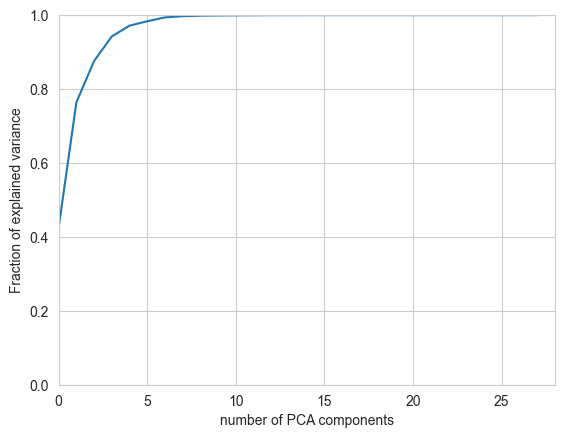

In [10]:
PCA_COMPONENT_COUNT = 28
cumulative_variance = image_pca_model.explained_variance_ratio_.cumsum()
plt.figure()
plt.axis([0, PCA_COMPONENT_COUNT,0,1])
plt.xlabel("number of PCA components")
plt.ylabel('Fraction of explained variance')
plt.plot(cumulative_variance)

### Reconstruction from just the first few components

In [11]:
# Run the PCA with a limited number of components.
reduced_training_image = extract_image_vector(image_index).reshape(ROW_COUNT,ROW_COUNT).T
image_pca_model = PCA(n_components=REDUCED_COMPONENT_COUNT)
image_pca_model.fit(reduced_training_image)
reduced_image_space = image_pca_model.transform(reduced_training_image)
print('Dimensions of the reduced PCA matrix: ',reduced_image_space.shape)
reduced_image_reconstruction = image_pca_model.inverse_transform(reduced_image_space)
print('Error: ',mean_square_error(reduced_image_reconstruction.reshape(784), reduced_training_image.reshape(784)))
show(view_one_image(reduced_image_reconstruction.flatten()))

Dimensions of the reduced PCA matrix:  (28, 8)
Error:  0.1281518277248641


### An alternate approach: Choose several images of the same character as components.

In [12]:
# Load the labels for this image set.
image_labels = pd.read_parquet('emnist_labels.parquet')
image_labels.shape

(18800, 1)

In [13]:
pca_model = PCA(n_components=REDUCED_COMPONENT_COUNT)

# Select a matrix of multiple images of the same digit
DIGIT = 9
multiple_images = np.zeros((REDUCED_COMPONENT_COUNT, ROW_COUNT*ROW_COUNT))
row = 0
for k in range(images.shape[0]):
    encoding = int(image_labels.loc[k])
    # print(encoding, end = ':')
    if encoding == DIGIT:
        print(k, encoding)
        a_digit = extract_image_vector(k)
        multiple_images[row,:] = extract_image_vector(k)
        row +=1
        if row >= REDUCED_COMPONENT_COUNT:
            break

print(f'Training shape {multiple_images.shape}')
pca_model.fit(multiple_images)
image_transform = pca_model.transform(multiple_images)
image_transform.shape

2 9
102 9
150 9
154 9
183 9
243 9
254 9
378 9
Training shape (8, 784)


/var/folders/_p/k447vbdn2758v4rk2mfj79jw0000gn/T/ipykernel_13996/2748958174.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  encoding = int(image_labels.loc[k])


(8, 8)

### We've compressed the 8 images of the same character into one 8 x 8 matrix.  

Let's view one of the reconstructed images.

In [14]:
reconstructed_image = pca_model.inverse_transform(image_transform)
print(reconstructed_image.shape)
show(view_one_image(reconstructed_image[2,:]))

(8, 784)


## Visualizing the first six eigenvector components

(8, 784)


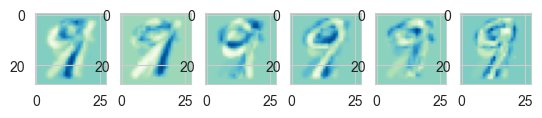

In [15]:
print(pca_model.components_.shape)
fit, axes = plt.subplots(1,6)
for k in range(6):
    axes[k].imshow(pca_model.components_[k,:].reshape(ROW_COUNT,ROW_COUNT).T, cmap='GnBu')

### How does error change for a noisy image, with the number of components?

In [16]:
# Corrupt an image by adding Gaussian noise to the pixels.
# This produces a speckled image

noisy_image = add_gaussian_noise(extract_image_vector(image_index),GAUSSIAN_NOISE_STD_DEV)
show(view_one_image(noisy_image))

## How can you reconstruct a noisy image?

By varying the number of components in the PCA reconstruction, can the signal to noise of the reconstructed image be reduced?

The presumption is that the first several components of PCA contain the image signal, and the latter ones mainly noise.

## 1. Compare the reconstruction error over a few different images - does the rate of decrease in error depend on the image?

Can you improve the PCA reconstruction error — find a way that uses either fewer PCA components, or obtains less error with the same number of components?

1. Compare the reconstruction error over a few different images:
    - compute the reconstruction error for multiple images using different numbers of PCA components.
    - analyze whether the rate of decrease in error 

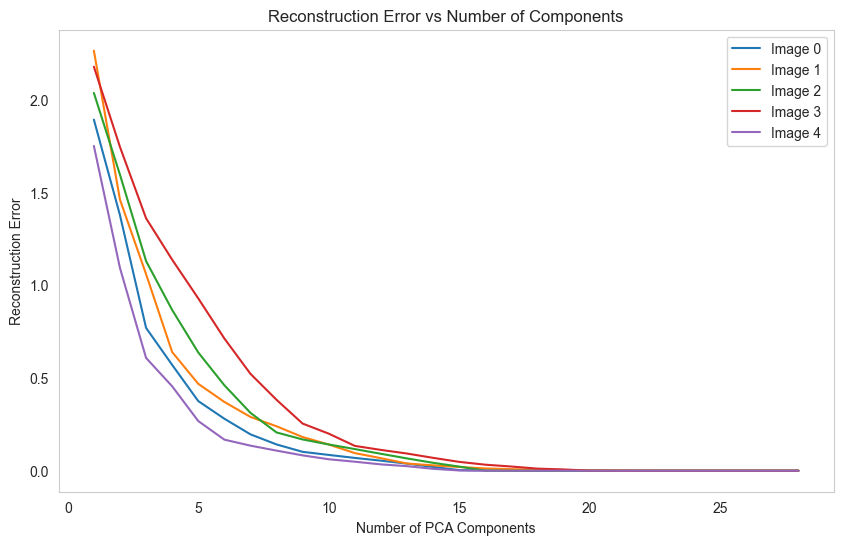

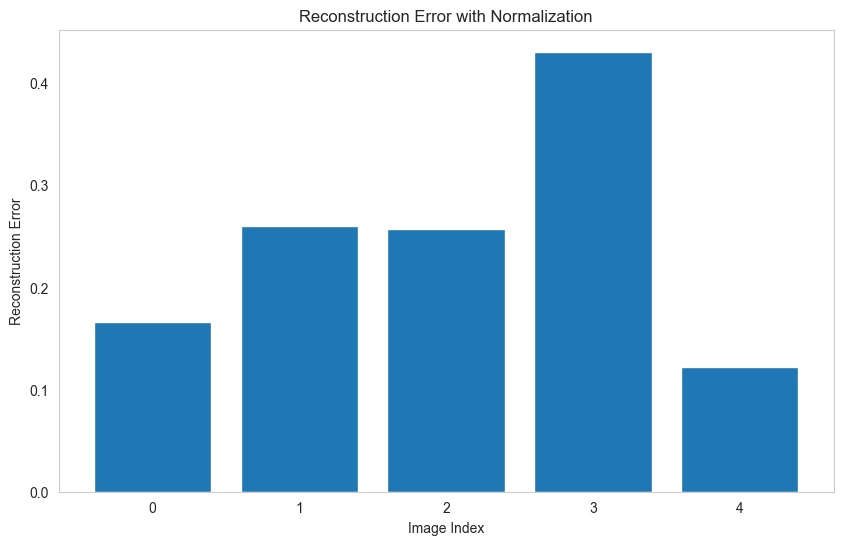

In [17]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Compare reconstruction error for multiple images
def compare_reconstruction_error(images, n_components_range):
    errors = {}  # To store errors for each image
    for image_index in range(len(images)):  # Iterate over a few images
        original_image = images[image_index]
        errors[image_index] = []
        
        for n_components in n_components_range:
            # Apply PCA with the given number of components
            pca_model = PCA(n_components=n_components)
            pca_model.fit(original_image)
            
            # Transform and inverse transform (reconstruct the image)
            reduced_space = pca_model.transform(original_image)
            reconstructed_image = pca_model.inverse_transform(reduced_space)
            
            # Calculate reconstruction error
            error = mean_square_error(original_image.flatten(), reconstructed_image.flatten())
            errors[image_index].append(error)
    
    # Plot the reconstruction error
    plt.figure(figsize=(10, 6))
    for image_index, error_list in errors.items():
        plt.plot(n_components_range, error_list, label=f"Image {image_index}")
    plt.xlabel("Number of PCA Components")
    plt.ylabel("Reconstruction Error")
    plt.title("Reconstruction Error vs Number of Components")
    plt.legend()
    plt.grid()
    plt.show()
    return errors

# Improving PCA reconstruction
def improve_pca_reconstruction(images, n_components):
    errors = {}
    for image_index in range(len(images)):
        original_image = images[image_index]
        
        # Option 1: Normalize the image
        scaler = StandardScaler()
        normalized_image = scaler.fit_transform(original_image)
        
        # Apply PCA
        pca_model = PCA(n_components=n_components)
        pca_model.fit(normalized_image)
        
        # Transform and inverse transform
        reduced_space = pca_model.transform(normalized_image)
        reconstructed_image = pca_model.inverse_transform(reduced_space)
        
        # Rescale back to the original range
        reconstructed_image_rescaled = scaler.inverse_transform(reconstructed_image)
        
        # Calculate reconstruction error
        error = mean_square_error(original_image.flatten(), reconstructed_image_rescaled.flatten())
        errors[image_index] = error
    
    # Plot the reconstruction errors
    plt.figure(figsize=(10, 6))
    plt.bar(errors.keys(), errors.values())
    plt.xlabel("Image Index")
    plt.ylabel("Reconstruction Error")
    plt.title("Reconstruction Error with Normalization")
    plt.grid()
    plt.show()
    return errors

# Example usage
n_components_range = range(1, 29)  # PCA components to test
images = [extract_image_vector(i).reshape(28, 28) for i in range(5)]  # Test first 5 images

# Compare reconstruction error
errors = compare_reconstruction_error(images, n_components_range)

# Improve PCA reconstruction
improved_errors = improve_pca_reconstruction(images, n_components=8)



# Code to Solve Problem 3: Optimal Number of Reconstruction Components for Noisy Images
An optimal number of PCA reconstruction components to improve the signal-to-noise ratio (SNR) for a noisy image:

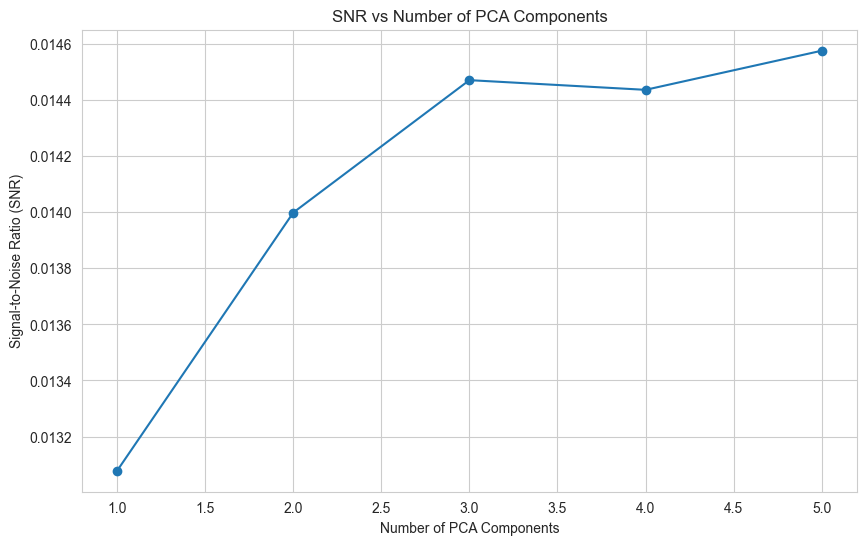

Optimal number of PCA components: 5


In [21]:
# Parameters
ROW_COUNT = 28  # Example for EMNIST images (28x28)
COLUMN_COUNT = 28  # For the image size
TOTAL_PIXELS = ROW_COUNT * COLUMN_COUNT

if isinstance(images, list):
    images = np.array(images)

# Measure Signal-to-Noise Ratio (SNR)
def calculate_snr(original_image, noisy_image, reconstructed_image):
   # Calculate the error between the noisy image and the reconstruction
   reconstruction_error = mean_square_error(noisy_image, reconstructed_image)
   noise_level = np.linalg.norm(noisy_image - original_image)  # noise in the noisy image
   return reconstruction_error / noise_level


# Select an image and generate a noisy version
image_index = rn.choice(images.shape[0])
original_image = extract_image_vector(image_index)
noisy_image = add_gaussian_noise(original_image)

# Apply PCA and reconstruct images with varying numbers of components
pca_model = PCA()

# Limit components to at most the number of features (28)
components_range = range(1, min(28, images.shape[0]) + 1)  # 1 to 28 (max 28 components)
snr_values = []

for components in components_range:
   pca_model.n_components = components
   pca_model.fit(original_image.reshape(ROW_COUNT, ROW_COUNT).T)

   # Transform the image to reduced PCA space and then reconstruct it
   image_space = pca_model.transform(original_image.reshape(ROW_COUNT, ROW_COUNT).T)
   reconstructed_image = pca_model.inverse_transform(image_space)

   # Calculate SNR
   snr = calculate_snr(original_image, noisy_image, reconstructed_image.flatten())
   snr_values.append(snr)

# Plot the SNR vs Number of Components
plt.figure(figsize=(10, 6))
plt.plot(components_range, snr_values, marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Signal-to-Noise Ratio (SNR)')
plt.title('SNR vs Number of PCA Components')
plt.grid(True)
plt.show()

# Find the optimal number of components with the highest SNR
optimal_components = components_range[np.argmax(snr_values)]
print(f'Optimal number of PCA components: {optimal_components}')